# Одномерный фильтр Калмана

In [1]:
%matplotlib inline

In [2]:
#format the book
import book_format
book_format.set_style()

"Одномерный" означает, что фильтр отслеживает только одну переменную состояния, такую как положение на оси x. Многомерная форма фильтра может отслеживать множество переменных состояния одновременно, таких как положение, скорость и ускорение. Фильтр Калмана - байесовский фильтр, использующий гауссов.

## Описание проблемы

Предположим у нас есть датчик. Датчик возвращает расстояние объекта от левого конца коридора в метрах. Таким образом, 23,4 будет означать, что объект находится в 23,4 метрах от левого конца коридора.

Датчик не идеален. Значение 23,4 может соответствовать объекту, который находиться на уровне 23,7 или 23,0. Однако это очень маловероятно, чтобы соответствовать позиции 47,6. Кроме того, ошибки, казалось, были равномерно распределены по обе стороны от истинного положения; положение 23 м с равной вероятностью будет измерено как 22,9 или 23,1. Возможно, мы можем смоделировать это с помощью гауссова фильтра.

Мы предсказываем, что объект движется. Это предсказание не является совершенным. Иногда наше предсказание будет завышено, иногда оно будет занижено. Мы с большей вероятностью промахнемся или промахнемся немного, чем сильно.

#### Гауссовский подход

Допустим, мы считаем, что наш объект находится на высоте 10 метров, дисперсия в этом убеждении составляет 1 м$^2$, или $\mathcal{N}(10,\, 1)$.

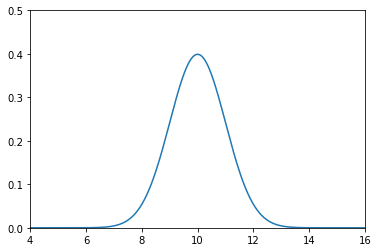

In [3]:
import filterpy.stats as stats
stats.plot_gaussian_pdf(mean=10., variance=1., 
                        xlim=(4, 16), ylim=(0, .5));

График показывает нашу неуверенность в положении объекта.  Мы считаем, что наиболее вероятно, что объект находится на расстоянии 10 м, любая позиция от 9 м до 11 м или около того также вполне вероятна. Предположим, что объект стоит неподвижно, и мы снова запрашиваем датчик. На этот раз он возвращает 10,2 м. Можем ли мы использовать эту дополнительную информацию для улучшения нашей оценки?

Интуиция подсказывает, что мы можем. Подумайте: если мы считываем датчик 500 раз и каждый раз он возвращает значение от 8 до 12, все сосредоточено вокруг 10, мы должны быть очень уверены, что объект находиться около 10 метров. Конечно, возможна и иная интерпретация. Возможно, наша объект беспорядочно бродила взад и вперед таким образом, что в точности имитировал случайное семплирование из нормального распределения.  Посмотрим на 500 семплов из$\mathcal N(10, 1)$:

Mean of readings is 10.045


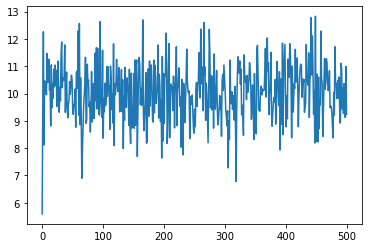

In [4]:
import numpy as np
from numpy.random import randn
import matplotlib.pyplot as plt

xs = range(500)
ys = randn(500)*1. + 10.
plt.plot(xs, ys)
print(f'Mean of readings is {np.mean(ys):.3f}')

## Отслеживание с гауссовскими вероятностями

Дискретный фильтр Байеса использует гистограмму вероятностей для отслеживания объекта. Каждая ячейка на гистограмме представляет позицию, а значение - вероятность того, что объект окажется в этой позиции.

$$\begin{aligned} 
\bar {\mathbf x} &= \mathbf x \ast f_{\mathbf x}(\bullet)\, \, &\text{Predict} \\
\mathbf x &= \mathcal L \cdot \bar{\mathbf x}\, \, &\text{Update}
\end{aligned}$$

для вычисления новых распределений вероятностей. Помним, что $\bar{\mathbf x}$ это *априорная*, $\mathcal L$ это *правдоподобие* измерения с учетом предшествующего $\bar{\mathbf x}$, $f_{\mathbf x}(\bullet)$ , $\ast$. $\mathbf x$ выделено жирным шрифтом, чтобы обозначить, что это гистограмма чисел или вектор.

Этот метод работает, но привел к гистограммам, которые подразумевали, что объект может находиться в нескольких местах одновременно. Кроме того, вычисления очень медленные для больших задач.

Можно ли заменить $\mathbf x$, гистограмму Гауссовским распределением $\mathcal N(x, \sigma^2)$?. Да такое распределение $\mathcal N(\mu, \sigma^2),$ может заменить всю гистограмму вероятностей:

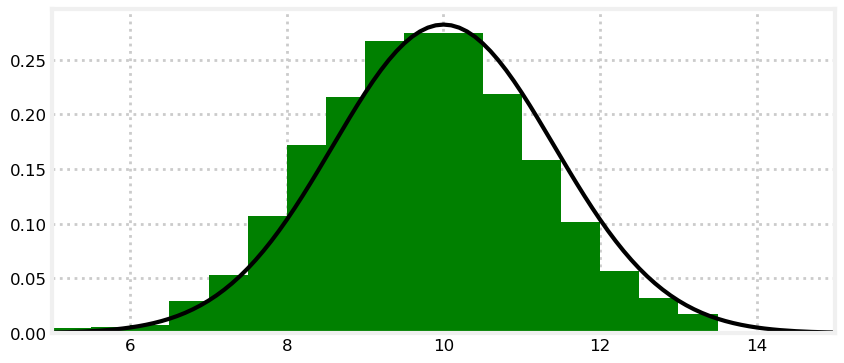

In [5]:
import kf_book.kf_internal as kf_internal
kf_internal.gaussian_vs_histogram()

Мы можем заменить сотни или тысячи чисел одной парой чисел: $x = \mathcal N(\mu, \sigma^2)$.

Хвосты гаусса простираются до бесконечности с обеих сторон, поэтому он включает в себя произвольное количество баров на гистограмме. Если это отражает нашу веру в положение объекта, распределение охватывает все пространство. Мы думаем, что, скорее всего, объект находится в 10, но он может быть в 8, 14 или, с бесконечно малой вероятностью, в 10$^{80}$.

Заменим гистограммы гауссовыми:

$$\begin{array}{l|l|c}
\text{discrete Bayes} & \text{Gaussian} & \text{Step}\\
\hline
\bar {\mathbf x} = \mathbf x \ast f(\mathbf x) & 
\bar {x}_\mathcal{N} =  x_\mathcal{N} \, \oplus \, f_{x_\mathcal{N}}(\bullet) &
\text{Predict} \\
\mathbf x = \|\mathcal L \bar{\mathbf x}\| & x_\mathcal{N} = L \, \otimes \, \bar{x}_\mathcal{N} & \text{Update} 
\end{array}$$

где $\oplus$ и $\otimes$ предназначены для выражения некоторого неизвестного оператора на гауссовом языке. Подстрочный индекс указывает, что $x_\mathcal{N}$ является гауссовым.

Дискретный фильтр Байеса использовал свертку для прогнозирования и *теорему о полной вероятности*, вычисленную как сумму, так что, возможно, мы сможем добавить гауссиан. Он использовал умножение, чтобы включить измерение в предыдущее, так что, возможно, мы сможем умножить гауссиан. Могло ли это быть так просто:

$$\begin{aligned} 
\bar x &\stackrel{?}{=} x + f_x(\bullet) \\
x &\stackrel{?}{=} \mathcal L \cdot \bar x
\end{aligned}$$

Это сработает только в том случае, если сумма и произведение двух гауссиан будут другими гауссианами. В противном случае после первой эпохи $x$ не был бы гауссовым, и эта схема разваливается.

## Предсказание с помощью Гауссовских процессов

Используем уравнение движения Ньютона для вычисления текущего положения на основе текущей скорости и предыдущего положения:

$$ \begin{aligned}\bar{x}_k &= x_{k-1} + v_k \Delta t \\
 &= x_{k-1} + f_x\end{aligned}$$

Объект находится на высоте 10 м, ее скорость составляет 15 м/с, а эпоха длится 2 секунды.

$$ \begin{aligned} f_x &= v\Delta t = 15\cdot 2\\
\bar{x}_k &= 10 + (15\cdot 2) = 40 \end{aligned}$$

Мы не уверены в его текущем положении и скорости. Нам нужно выразить неопределенность с помощью Гаусса. Определяем $x$ как гауссовский процесс. Если мы думаем, что собака находится на расстоянии 10 м, а стандартное отклонение нашей неопределенности составляет 0,2 м, мы получаем $x=\mathcal N(10, 0,2^2)$.

А как насчет нашей неуверенности в его движении? Мы определяем $f_x$ как гауссовский. Если скорость собаки составляет 15 м/с, эпоха составляет 1 секунду, а стандартное отклонение нашей неопределенности составляет 0,7 м/с, мы получаем $f_x = \mathcal N (15, 0,7^2)$.


$$\bar x = x + f_x$$

Какова сумма двух гауссиан?

$$\begin{gathered}
\mu = \mu_1 + \mu_2 \\
\sigma^2 = \sigma^2_1 + \sigma^2_2
\end{gathered}$$

Сумма двух гауссиан - это еще один гауссиан. Математика работает, но имеет ли это интуитивный смысл? Подумайте о физическом представлении этого абстрактного уравнения. У нас есть

$$\begin{gathered}
x=\mathcal N(10, 0.2^2)\\
f_x = \mathcal N (15, 0.7^2)
\end{gathered}$$


$$\begin{aligned}\bar x &= \mu_x + \mu_{f_x} = 10 + 15 &&= 25 \\
\bar\sigma^2 &= \sigma_x^2 + \sigma_{f_x}^2 = 0.2^2 + 0.7^2 &&= 0.53\end{aligned}$$

Предсказанная позиция - это предыдущая позиция плюс движение. А как насчет дисперсии? Мы на самом деле не знаем, куда движется объект, поэтому уверенность должна уменьшаться (дисперсия увеличивается). $\sigma_{f_x}^2$ - это величина неопределенности, добавленная в систему из-за несовершенного прогноза движения, и поэтому мы бы добавили это к существующей неопределенности.

In [5]:
from collections import namedtuple
gaussian = namedtuple('Gaussian', ['mean', 'var'])
gaussian.__repr__ = lambda s: '𝒩(μ={:.3f}, 𝜎²={:.3f})'.format(s[0], s[1])

In [6]:
g1 = gaussian(3.4, 10.1)
g2 = gaussian(mean=4.5, var=0.2**2)
print(g1)
print(g2)

𝒩(μ=3.400, 𝜎²=10.100)
𝒩(μ=4.500, 𝜎²=0.040)


In [7]:
g1.mean, g1[0], g1[1], g1.var

(3.4, 3.4, 10.1, 10.1)

Реализация функции прогнозирования, где "позиция" и "движение" являются гауссовыми кортежами в виде ($\mu$, $\sigma^2$):

In [8]:
def predict(pos, movement):
    return gaussian(pos.mean + movement.mean, pos.var + movement.var)

In [9]:
pos = gaussian(10., .2**2)
move = gaussian(15., .7**2)
predict(pos, move)

𝒩(μ=25.000, 𝜎²=0.530)

## Обновление прогноза

Дискретный фильтр Байеса кодирует наше представление о положении нашей собаки в гистограмме вероятностей. Распределение является дискретным и мультимодальным. Это может выражать твердое убеждение в том, что собака находится в двух положениях одновременно, и эти положения являются дискретными.

Заменим априорное и апостриорнаое распределение на гауссовы, и их произведение будет также гауссовым. 

$$\begin{aligned}
\mu &= \frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{\sigma_1^2\sigma_2^2}{\sigma_1^2+\sigma_2^2}
\end{aligned}$$

Мы можем сразу сделать несколько выводов. Если мы нормализуем результат, то продукт будет другим гауссовым. Если один гауссовский - это вероятность, а второй - предыдущий, то среднее значение представляет собой масштабированную сумму предыдущего и измерения. Отклонение представляет собой комбинацию отклонений от предыдущего и измерения. Наконец, на отклонения совершенно не влияют значения среднего значения!

Выражаем это в байесовских терминах примерно так:

$$\begin{aligned}
\mathcal N(\mu, \sigma^2) &= \| prior \cdot likelihood \|\\
&= \| \mathcal{N}(\bar\mu, \bar\sigma^2)\cdot \mathcal{N}(\mu_z, \sigma_z^2) \|\\
&= \mathcal N(\frac{\bar\sigma^2 \mu_z + \sigma_z^2 \bar\mu}{\bar\sigma^2 + \sigma_z^2},\frac{\bar\sigma^2\sigma_z^2}{\bar\sigma^2 + \sigma_z^2})
\end{aligned}$$

In [10]:
def gaussian_multiply(g1, g2):
    mean = (g1.var * g2.mean + g2.var * g1.mean) / (g1.var + g2.var)
    variance = (g1.var * g2.var) / (g1.var + g2.var)
    return gaussian(mean, variance)

def update(prior, likelihood):
    posterior = gaussian_multiply(likelihood, prior)
    return posterior

predicted_pos = gaussian(10., .2**2)
measured_pos = gaussian(11., .1**2)
estimated_pos = update(predicted_pos, measured_pos)
estimated_pos

𝒩(μ=10.800, 𝜎²=0.008)

### 

Построим $\mathcal{N}(10,\, 1) \раз \mathcal{N}(10,\, 1)$. Можно ли определить его форму, не глядя на результат? Каким должно быть новое значение? Будет ли кривая шире, уже или такой же, как $\mathcal{N}(10,\, 1)$?

𝒩(μ=10.000, 𝜎²=0.500)


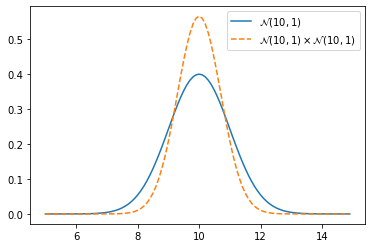

In [11]:
z = gaussian(10., 1.)  # Gaussian N(10, 1)

product = gaussian_multiply(z, z)

xs = np.arange(5, 15, 0.1)
ys = [stats.gaussian(x, z.mean, z.var) for x in xs]
plt.plot(xs, ys, label='$\mathcal{N}(10,1)$')

ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
plt.plot(xs, ys, label='$\mathcal{N}(10,1) \\times \mathcal{N}(10,1)$', ls='--')
plt.legend()
print(product)

Результат умножения выше и уже, чем исходный гауссовский, но среднее значение остается неизменным. 

Думайте о гауссианах как о двух измерениях. Если я измеряю дважды и каждый раз получаю 10 метров, я должен сделать вывод, что длина близка к 10 метрам. Таким образом, среднее значение должно быть 10. Было бы бессмысленно делать вывод, что длина на самом деле составляет 11 или 9,5. Кроме того, я более уверен в двух измерениях, чем в одном, поэтому отклонение результата должно быть меньше.

"Отмерь дважды, отрежь один раз" - хорошо известная поговорка. Гауссово умножение является математической моделью этого физического факта.

Я вряд ли получу одно и то же измерение дважды подряд. Построим pdf-файл $\mathcal{N}(10.2,\, 1) \раз\mathcal{N}(9.7,\, 1)$.

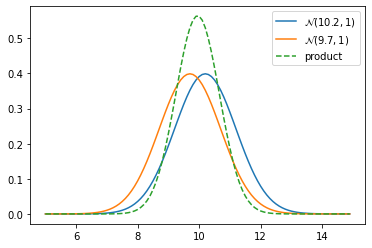

In [12]:
def plot_products(g1, g2): 
    plt.figure()
    product = gaussian_multiply(g1, g2)

    xs = np.arange(5, 15, 0.1)
    ys = [stats.gaussian(x, g1.mean, g1.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$'+'$({},{})$'.format(g1.mean, g1.var))

    ys = [stats.gaussian(x, g2.mean, g2.var) for x in xs]
    plt.plot(xs, ys, label='$\mathcal{N}$'+'$({},{})$'.format(g2.mean, g2.var))

    ys = [stats.gaussian(x, product.mean, product.var) for x in xs]
    plt.plot(xs, ys, label='product', ls='--')
    plt.legend();
    
z1 = gaussian(10.2, 1)
z2 = gaussian(9.7, 1)
 
plot_products(z1, z2)

Если вы попросите двух человек измерить расстояние от стола до стены, и один получит 10,2 метра, а другой - 9,7 метра, ваше лучшее предположение должно быть средним, 9,95 метра, если вы одинаково доверяете навыкам обоих. Это становится нелогичным в более сложных ситуациях, поэтому давайте рассмотрим это подробнее. Возможно, более разумным предположением было бы, что один человек допустил ошибку, и истинное расстояние составляет либо 10,2, либо 9,7, но, конечно, не 9,95. Конечно, это возможно. Но мы знаем, что у нас есть шумные измерения, поэтому у нас нет оснований думать, что одно из измерений не имеет шума или что один человек допустил грубую ошибку, которая позволяет нам отказаться от их измерения. Учитывая всю имеющуюся информацию, наилучшая оценка должна составлять 9,95.

На этапе обновления фильтра Калмана мы объединяем не два измерения, а одно измерение и предыдущую, нашу оценку перед включением измерения.

Давайте посмотрим на это. Я создам довольно неточное априорное распределение $\mathcal N(8,5, 1,5)$ и более точное измерение $\mathcal N(10,2, 0,5).$ Под "точным" я подразумеваю, что дисперсия датчика меньше, чем дисперсия первого. Постролим обратную зависимость: точное априорное распределение $\mathcal N(8,5, 0,5)$ и неточное измерение $\mathcal N(10,2, 1,5)$.

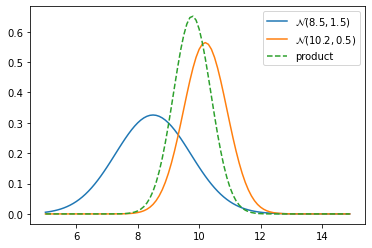

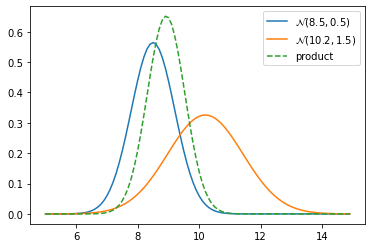

In [13]:
prior, z = gaussian(8.5, 1.5), gaussian(10.2, 0.5)
plot_products(prior, z)

prior, z = gaussian(8.5, 0.5), gaussian(10.2, 1.5)
plot_products(prior, z)

В результате получается гауссовский процесс, который выше, чем любой из входных данных. Это имеет смысл - мы включили информацию, поэтому наше расхождение должно было быть уменьшено. И обратите внимание, как результат намного ближе к входным данным с меньшей дисперсией. Мы больше уверены в этой ценности, поэтому имеет смысл придавать ей большее значение.

### Пример

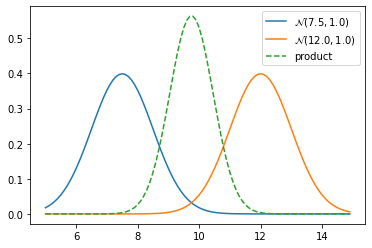

In [14]:
from ipywidgets import interact

def interactive_gaussian(m1, m2, v1, v2):
    g1 = gaussian(m1, v1)
    g2 = gaussian(m2, v2)
    plot_products(g1, g2)
    
interact(interactive_gaussian,
         m1=(5, 10., .5), m2=(10, 15, .5), 
         v1=(.1, 2, .1), v2=(.1, 2, .1));

## First Kalman Filter

In [16]:
import kf_book.kf_internal as kf_internal
from kf_book.kf_internal import ObjectSimulation

np.random.seed(13)

process_var = 1. # variance in the object movement
sensor_var = 2. # variance in the sensor

x = gaussian(0., 20.**2)  # object position, N(0, 20**2)
velocity = 1
dt = 1. # time step in seconds
process_model = gaussian(velocity*dt, process_var) # displacement to add to x
  
# simulate dog and get measurements
object_class = ObjectSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

# create list of measurements
zs = [object_class.move_and_sense() for _ in range(10)]

In [17]:
print('PREDICT\t\t\tUPDATE')
print('     x      var\t\t  z\t    x      var')

# perform Kalman filter on measurement z
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    kf_internal.print_gh(prior, x, z)

print()
print('final estimate:        {:10.3f}'.format(x.mean))
print('actual final position: {:10.3f}'.format(dog.x))

PREDICT			UPDATE
     x      var		  z	    x      var
  1.000  401.000	1.354	  1.352   1.990
  2.352    2.990	1.882	  2.070   1.198
  3.070    2.198	4.341	  3.736   1.047
  4.736    2.047	7.156	  5.960   1.012
  6.960    2.012	6.939	  6.949   1.003
  7.949    2.003	6.844	  7.396   1.001
  8.396    2.001	9.847	  9.122   1.000
 10.122    2.000	12.553	 11.338   1.000
 12.338    2.000	16.273	 14.305   1.000
 15.305    2.000	14.800	 15.053   1.000

final estimate:            15.053
actual final position:     14.838


Вот анимация фильтра. Прогнозы отображаются красным треугольником. После предсказания фильтр получает следующее измерение, отображенное в виде черного круга. Затем фильтр формирует оценку на полпути между ними.

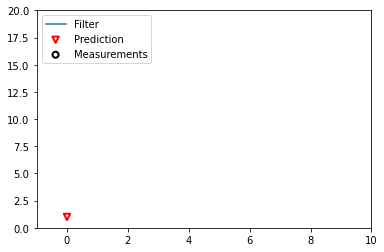

In [18]:
from kf_book import book_plots as book_plots
from ipywidgets.widgets import IntSlider

# save output in these lists for plotting
xs, predictions = [], []

process_model = gaussian(velocity, process_var) 

# perform Kalman filter
x = gaussian(0., 20.**2)
for z in zs:    
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)

    # save results
    predictions.append(prior.mean)
    xs.append(x.mean)

def plot_filter(step):
    plt.cla()
    step -= 1
    i = step // 3 + 1
 
    book_plots.plot_predictions(predictions[:i])    
    if step % 3 == 0:
        book_plots.plot_measurements(zs[:i-1])
        book_plots.plot_filter(xs[:i-1])
    elif step % 3 == 1:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i-1])
    else:
        book_plots.plot_measurements(zs[:i])
        book_plots.plot_filter(xs[:i])

    plt.xlim(-1, 10)
    plt.ylim(0, 20)
    plt.legend(loc=2);
interact(plot_filter, step=IntSlider(value=1, min=1, max=len(predictions)*3));

I've plotted the prior (labeled *prediction*), the measurements, and the filter output. For each iteration of the loop we form a prior, take a measurement, form a likelihood from the measurement, and then incorporate the likelihood into the prior. 

If you look at the plot you can see that the filter estimate is always between the measurement and prediction. Recall that for the g-h filter we argued that the estimate must always be between the measurement and prior. It makes no sense to choose a value outside of the two values. If I predict I am at 10, but measure that I am at 9, it would be foolish to decide that I must be at 8, or 11.

## Разбор кода

```python
process_var = 1.
sensor_var = 2.
```
 
Это отклонения для модели процесса и датчика. Значение дисперсии датчика это то, насколько велика дисперсия в каждом измерении. Отклонение процесса - это то, насколько велика ошибка в модели процесса. Мы прогнозируем, что при каждом временном шаге объект продвигается вперед на один метр. Если бы это был робот, реагирующий на цифровые команды, производительность была бы намного лучше, и, возможно, разница составила бы $\sigma^2=.05$. 

```python
x = gaussian(0., 20.**2)
```

Это начальное положение, выраженное как гауссово. Позиция равна 0 метрам, а отклонение составляет 400  м$^2$, что является стандартным отклонением в 20 метров. Вы можете думать об этом так: "Я считаю, что с точностью 99,7 % положение равно 0 плюс-минус 60 метров". Это связано с тем, что с гауссианами ~99,7 % значений попадают в $\pm3\sigma$ среднего.

```python
process_model = gaussian(velocity, process_var)
```

Это модель процесса - описание того, как, по нашему мнению, движется объект. Как мне узнать скорость? Считайте это предсказанием, или, возможно, у нас есть вторичный датчик скорости. Если это робот, то это будет управляющий вход для робота. 

Затем мы инициализируем моделирование и создадим 10 измерений:

```python
Obj = ObjectSimulation(
    x0=x.mean, 
    velocity=process_model.mean, 
    measurement_var=sensor_var, 
    process_var=process_model.var)

zs = [Obj.move_and_sense() for _ in range(10)]
```


```python
for z in zs:
    prior = predict(x, process_model)
    likelihood = gaussian(z, sensor_var)
    x = update(prior, likelihood)
```

Первый раз через цикл "до" - это "(1.0, 401.0)", как видно из печатной таблицы. После прогноза мы считаем, что мы находимся на уровне 1,0, и отклонение теперь составляет 401, по сравнению с 400. Дисперсия ухудшилась, что всегда происходит на этапе прогнозирования, потому что это связано с потерей информации.

Затем мы вызываем функцию обновления, используя "предыдущую" в качестве текущей позиции.

Для этого я получаю в результате следующее: "pos = (1.352, 1.990), z = 1.354".

Что происходит? Объект на самом деле находится на уровне 1,0, но измеренное положение равно 1,354 из-за шума датчика. Это довольно далеко от прогнозируемого значения 1. Отклонение от предыдущего составляет 401 м$^2$. Большая дисперсия подразумевает, что достоверность очень низкая, поэтому фильтр оценивает позицию как очень близкую к измерению: 1,352.

Теперь посмотрите на дисперсию: 1,99 м$^2$. Она значительно снизилась с 401 м$^2$. Почему? Что ж, датчик имеет достаточно небольшую дисперсию в 2,0 м$^2$, поэтому мы доверяем ему гораздо больше, чем предыдущему. Однако предыдущее убеждение содержит немного полезной информации, поэтому наша дисперсия теперь немного меньше 2,0.

Зашумленные измерения отображаются черными кружками, а результаты фильтрации отображаются сплошной синей линией. Оба довольно шумные, но обратите внимание, насколько более шумными являются измерения. Я построил прогноз (предыдущий) с красными треугольниками. Оценка всегда находится между предыдущим и измерением. 


```python
prior = predict(x, process_model)
likelihood = gaussian(z, sensor_var)
x = update(prior, likelihood)
```


```python
for z in zs:
    # predict
    dx = velocity*dt
    pos = pos + dx
    var = var + process_var

    # update
    pos  = (var*z + sensor_var*pos) / (var + sensor_var)
    var = (var * sensor_var) / (var + sensor_var)
```    

Посмотрим на производительность фильтра с большим количеством данных. Отклонение отображается в виде слегка заштрихованной желтой области между пунктирными линиями. Я увеличил размер процесса и дисперсию датчиков, чтобы их было легче увидеть на графике.

	4.4502 2.6507 2.2871 2.1955 2.1712
	2.1647 2.1629 2.1625 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623
	2.1623 2.1623 2.1623 2.1623 2.1623


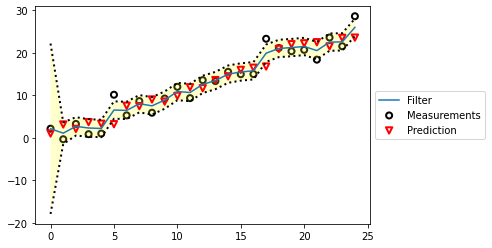

In [19]:
process_var = 2.
sensor_var = 4.5
x = gaussian(0., 400.)
process_model = gaussian(1., process_var)
N = 25

Obj = ObjectSimulation(x.mean, process_model.mean, sensor_var, process_var)
zs = [Obj.move_and_sense() for _ in range(N)]

xs, priors = np.zeros((N, 2)), np.zeros((N, 2))
for i, z in enumerate(zs):
    prior = predict(x, process_model)    
    x = update(prior, gaussian(z, sensor_var))
    priors[i] = prior
    
    xs[i] = x

book_plots.plot_measurements(zs)
book_plots.plot_filter(xs[:, 0], var=priors[:, 1])
book_plots.plot_predictions(priors[:, 0])
book_plots.show_legend()
kf_internal.print_variance(xs)

Здесь мы видим, что отклонение сходится к 2,1623 за 9 шагов. Это означает, что мы стали очень уверены в нашей оценке позиции. Это равно $\sigma=1.47$ метрам. При этом для датчика $\sigma=2.12$ метров. Первые несколько измерений неуверенны из-за нашей неопределенности начального положения, но фильтр быстро сходится к оценке с меньшей дисперсией, чем датчик.

Этот код полностью реализует фильтр Калмана. Более того, у еас есть хорошее интуитивное представление о том, что происходит. Мы представляем закон движения в виде гауссианы, и со временем наши прогнозы становятся лучше, потому что больше измерений означает, что у нас больше данных для работы.

### Иллюстрация

<img src='animations/05_dog_track.gif'>

На верхнем графике вывод фильтра показан зеленым цветом, а измерения - пунктирной красной линией. На нижнем графике показан гауссовское распределение на каждом шаге.

Когда трек только начинается, вы можете видеть, что измерения довольно сильно отличаются от первоначального прогноза. В этот момент вероятность Гаусса мала (кривая низкая и широкая), поэтому фильтр не доверяет своему прогнозу. В результате фильтр корректирует свою оценку на большую величину. По мере обновления фильтра вы можете видеть, что по мере того, как гауссовский становится выше, что указывает на большую достоверность оценки, выходные данные фильтра становятся очень близкими к прямой линии. При `x=15` и выше вы можете видеть, что в измерении присутствует большое количество шума, но фильтр не сильно реагирует на него по сравнению с тем, насколько он изменился при первом шумном измерении.

## Kalman Gain

Мы видим, что фильтр работает. Теперь давайте вернемся к математике, чтобы понять, что происходит. Апостериорная вероятность $x$ вычисляется как вероятность, умноженная на предыдущую ($\mathcal L\bar x$), где оба являются гауссианами.

Среднее

$$
\mu=\frac{\bar\sigma^2\, \mu_z + \sigma_z^2 \, \bar\mu} {\bar\sigma^2 + \sigma_z^2}
$$


$$\mu = \left( \frac{\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}\right) \mu_z + \left(\frac{\sigma_z^2}{\bar\sigma^2 + \sigma_z^2}\right)\bar\mu$$

В этой формуле легко увидеть, что мы масштабируем измерение и предыдущее по весам:

$$\mu = W_1 \mu_z + W_2 \bar\mu$$


Веса суммируются до единицы, потому что знаменатель является термином нормализации. Мы вводим новый термин, $K=W_1$:

$$\begin{aligned}
\mu &= K \mu_z + (1-K) \bar\mu\\
&= \bar\mu + K(\mu_z - \bar\mu)
\end{aligned}$$

где

$$K = \frac {\bar\sigma^2}{\bar\sigma^2 + \sigma_z^2}$$

$K$ это *Калмановский коэфициент усиления*. В этом суть фильтра Калмана. Это термин масштабирования, который выбирает значение между $\mu_z$ and $\bar\mu$.

Давайте рассмотрим несколько примеров. Если измерение в девять раз точнее предыдущего, то $\bar\sigma^2 = 9\sigma_z^2$, и

$$\begin{aligned}
\mu&=\frac{9 \sigma_z^2 \mu_z + \sigma_z^2\, \bar\mu} {9 \sigma_z^2 + \sigma_\mathtt{z}^2} \\
&= \left(\frac{9}{10}\right) \mu_z + \left(\frac{1}{10}\right) \bar\mu
\end{aligned}
$$

Таким образом $K = \frac 9 {10}$, и чтобы сформировать апостериорное распределение, мы берем девять десятых измерения и одну десятую от предыдущей.

Если измерение и предыдущее одинаково точны, то $\bar\sigma^2 = \sigma_z^2$ и

$$\begin{gathered}
\mu=\frac{\sigma_z^2\,  (\bar\mu + \mu_z)}{2\sigma_\mathtt{z}^2} \\
= \left(\frac{1}{2}\right)\bar\mu + \left(\frac{1}{2}\right)\mu_z
\end{gathered}$$

что является средним из двух средних значений. Интуитивно имеет смысл взять среднее значение двух одинаково точных значений.

Мы также можем выразить дисперсию в терминах коэффициента Калмана:

$$\begin{aligned}
\sigma^2 &= \frac{\bar\sigma^2 \sigma_z^2 } {\bar\sigma^2 + \sigma_z^2} \\
&= K\sigma_z^2 \\
&= (1-K)\bar\sigma^2 
\end{aligned}$$


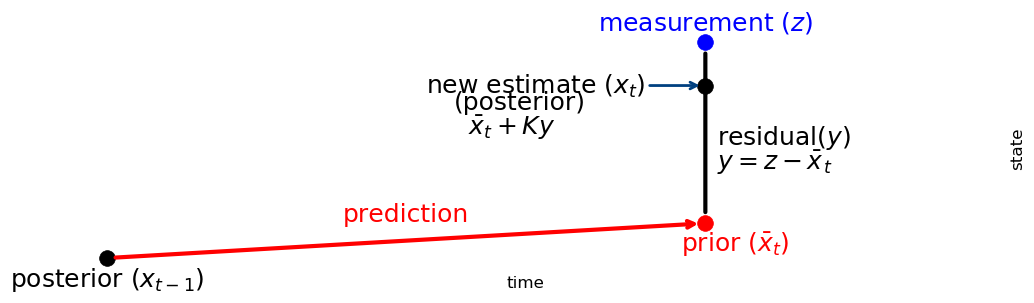

In [20]:
import kf_book.book_plots as book_plots
book_plots.show_residual_chart()

Это масштабирующий коэффициент, который выбирает значение среди остатков

In [21]:
def update(prior, measurement):
    x, P = prior        # mean and variance of prior
    z, R = measurement  # mean and variance of measurement
    
    y = z - x        # residual
    K = P / (P + R)  # Kalman gain

    x = x + K*y      # posterior
    P = (1 - K) * P  # posterior variance
    return gaussian(x, P)

def predict(posterior, movement):
    x, P = posterior # mean and variance of posterior
    dx, Q = movement # mean and variance of movement
    x = x + dx
    P = P + Q
    return gaussian(x, P)

Откуда берутся имена "z", "P", "Q" и "R"? В литературе $R$ почти повсеместно используется для шума измерения, $Q$ для шума процесса и $P$ для дисперсии состояния. Использование $z$ для измерения является обычным, хотя и не универсальным. Почти в каждой книге и статье, которые вы читаете, будут использоваться эти имена переменных.

Это также мощный способ подумать о фильтрации. Необходимо взять остаточный $y = \mu_z - \bar\mu$, найти коэффициент Калмана как отношение нашей неопределенности в предыдущем и измерении $K=P/(P+R)$ и вычислить апостериорное значение, добавив $Ky$ к предыдущему.




## Описание алгоритма

<img src="./figs/residual_chart.png">

 Фильтр Калмана делает прогноз, производит измерение, а затем формирует новую оценку где-то между ними.

**Это чрезвычайно важно понять**: Каждый фильтр реализует один и тот же алгоритм, просто с разными математическими деталями. Математика может стать сложной задачей, но идея проста для понимания.

Важно видеть детали уравнений конкретного фильтра и понимать, *что* вычисляют уравнения и *почему*. Существует огромное количество фильтров. Все они используют разную математику для реализации одного и того же алгоритма. Выбор математики влияет на качество результатов и на то, какие проблемы могут быть представлены, но не на лежащие в их основе идеи.

Вот общий алгоритм:

** Инициализация**

1. Инициализируйте начальное состояние фильтра
2. Инициализируйте тип распределения

** Прогноз**

1. Используйте поведение системы для прогнозирования состояния на следующем временном шаге
2. Скорректируйте убеждения, чтобы учесть неопределенность в прогнозе

** Обновление**

1. Получите измерение и связанное с ним вероятность в его точности
2. Вычислите остаток между оцененным состоянием и измерением
3. Вычислите коэффициент масштабирования на основе того, соответствует ли измерение или прогноз более точен
4. установите состояние между прогнозом и измерением на основе коэффициента масштабирования
5. обновите предсказание, основанное на том, насколько мы уверены в измерении

Вам будет трудно найти алгоритм байесовского фильтра, который не вписывается в эту форму. Некоторые фильтры не будут включать некоторые аспекты, такие как ошибка в прогнозировании, а другие будут иметь очень сложные методы вычислений, но это то, что они все делают.

Уравнения для одномерного фильтра Калмана следующие:

<u>Predict</u>

$\begin{array}{|l|l|l|}
\hline
\text{Equation} & \text{Implementation} & \text{Kalman Form}\\
\hline
 \bar x = x + f_x & \bar\mu = \mu + \mu_{f_x} & \bar x = x + dx\\
& \bar\sigma^2 = \sigma^2 + \sigma_{f_x}^2 & \bar P = P + Q\\
\hline
\end{array}$


<u>Update</u>

$\begin{array}{|l|l|l|}
\hline
\text{Equation} & \text{Implementation}& \text{Kalman Form}\\
\hline
 x = \| \mathcal L\bar x\| & y = z - \bar\mu & y = z - \bar x\\
 & K = \frac {\bar\sigma^2} {\bar\sigma^2 + \sigma_z^2} & K = \frac {\bar P}{\bar P+R}\\
 & \mu = \bar \mu + Ky & x = \bar x + Ky\\
 & \sigma^2 = \frac {\bar\sigma^2 \sigma_z^2} {\bar\sigma^2 + \sigma_z^2} & P = (1-K)\bar P\\
\hline
\end{array}$

## Разработка фильтра для датчика температуры

Датчик термометра выдает напряжение, соответствующее измеряемой температуре. Мы ознакомились со спецификациями производителя датчика, и в нем говорится, что датчик демонстрирует белый шум со стандартным отклонением 0,13 вольта.

С помощью этой функции мы можем имитировать измерение датчика температуры:

In [20]:
def volt(voltage, std):
    return voltage + (randn() * std)

Теперь нам нужно написать цикл обработки фильтра Калмана. Как и в случае с нашей предыдущей проблемой, нам необходимо выполнить цикл прогнозирования и обновления. У нас нет известного движения, поэтому мы установим его на ноль. Однако это означает, что мы прогнозируем, что температура никогда не изменится. Если это так, то со временем мы должны стать чрезвычайно уверенными в наших результатах. Как только фильтр получит достаточное количество измерений, он станет очень уверенным в том, что сможет предсказать последующие температуры, и это приведет к игнорированию измерений, которые получаются в результате фактического изменения температуры. Поэтому мы добавим немного ошибок к нашему шагу прогнозирования, чтобы указать фильтру не сбрасывать со счетов изменения напряжения с течением времени. В приведенном ниже коде я установил "process_var = .05**2". Это ожидаемая разница в изменении напряжения на каждом временном шаге. Я выбрал это значение просто для того, чтобы иметь возможность показать, как изменяется отклонение в ходе обновления и прогнозирования шагов. Для реального датчика вы бы установили это значение для фактической величины ожидаемых изменений. Например, это будет чрезвычайно малое число, если это термометр для измерения температуры окружающего воздуха в доме, и большое число, если это термопара в камере химической реакции. 

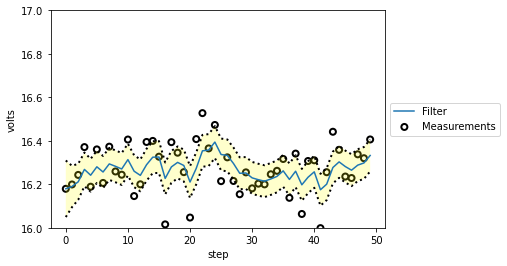

Variance converges to 0.005


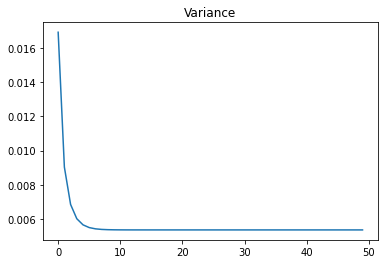

In [21]:
temp_change = 0
voltage_std = .13
process_var = .05**2
actual_voltage = 16.3

x = gaussian(25., 1000.) # initial state
process_model = gaussian(0., process_var)

N = 50
zs = [volt(actual_voltage, voltage_std) for i in range(N)]
ps = []
estimates = []

for z in zs:
    prior = predict(x, process_model)
    x = update(prior, gaussian(z, voltage_std**2))

    # save for latter plotting
    estimates.append(x.mean)
    ps.append(x.var)

# plot the filter output and the variance
book_plots.plot_measurements(zs)
book_plots.plot_filter(estimates, var=np.array(ps))
book_plots.show_legend()
plt.ylim(16, 17)
book_plots.set_labels(x='step', y='volts')
plt.show()
    
plt.plot(ps)
plt.title('Variance')
print('Variance converges to {:.3f}'.format(ps[-1]))

### Визуализация

<img src='animations/05_volt_animate.gif'>

Верхний график отображает зеленую линию для прогнозируемого следующего напряжения, затем красный "+" для фактического измерения, рисует светло-красную линию, чтобы показать остаток, а затем рисует синюю линию на выходе фильтра. Вы можете видеть, что при запуске фильтра внесенные поправки довольно велики, но после нескольких обновлений фильтр лишь немного корректирует свой вывод, даже если измерение находится далеко от него.

Нижний график показывает распределение Гаусса по мере обновления фильтра. Когда фильтр запускается, кривая Гаусса центрируется выше 25, что является нашим первоначальным предположением о напряжении, и она очень широкая и короткая из-за нашей начальной неопределенности. Но по мере внедрения новой информации в фильтр гауссовский быстро перемещается примерно до 16,0 и становится выше, что отражает растущую уверенность фильтра в его оценке напряжения. Вы также заметите, что высота колокола немного подпрыгивает вверх и вниз. Если вы внимательно посмотрите, вы увидите, что колокол становится немного короче и более растянутым на этапе прогнозирования, а также становится выше и уже по мере того, как фильтр включает в себя другое измерение.

## Сильно зашумеленный датчик

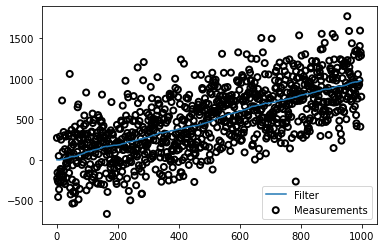

In [23]:
sensor_var = 300.**2
process_var = 2.
process_model = gaussian(1., process_var)
pos = gaussian(0., 500.)
N = 1000
obj = ObjectSimulation(pos.mean, 1., sensor_var, process_var)
zs = [obj.move_and_sense() for _ in range(N)]
ps = []

for i in range(N):
    prior = predict(pos, process_model)    
    pos = update(prior, gaussian(zs[i], sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

В этом примере шум очень сильный, но фильтр все равно выводит почти прямую линию. Мы получаем почти прямую линию, потому что наша ошибка процесса невелика. Небольшая ошибка процесса сообщает фильтру, что прогноз очень надежен, и прогноз представляет собой прямую линию, поэтому фильтр выводит почти прямую линию.

## Некорректная дисперсия процесса

Почему бы  не установить очень низкую дисперсию процесса, поскольку это гарантирует, что результат будет прямым и плавным?

Отклонение процесса указывает фильтру, насколько сильно система меняется с течением времени. Если вы обманете фильтр, установив это число искусственно низким, фильтр не сможет реагировать на происходящие изменения. Будем увеличивать скорость на небольшую величину на каждом временном шаге и посмотрим, как работает фильтр с дисперсией процесса 0,001 м$^2$.

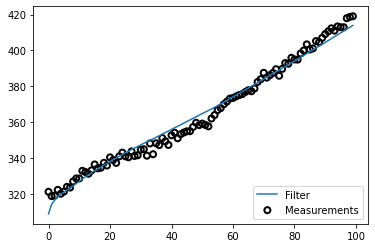

In [28]:
sensor_var = 20.
process_var = .001
process_model = gaussian(1., process_var)
pos = gaussian(0., 500.)
N = 100
obj = ObjectSimulation(pos.mean, 1, sensor_var, process_var*10000)
zs, ps = [], []
for _ in range(N):
    obj.velocity += 0.04
    zs.append(dog.move_and_sense())

for z in zs:
    prior = predict(pos, process_model)    
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

## Плохие начальные условия


Теперь давайте посмотрим на результаты, когда мы делаем плохую первоначальную оценку позиции. Чтобы избежать искажения результатов, я уменьшу отклонение датчика до 30, но установлю начальное положение на 1000 метров. Может ли фильтр восстановиться после ошибки в 1000 метров?

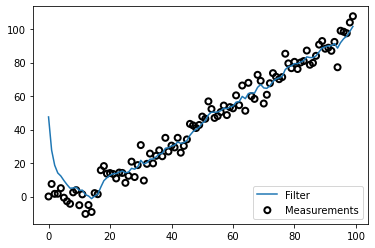

In [32]:
sensor_var = 5.**2
process_var = 2.
pos = gaussian(1000., 500.)
process_model = gaussian(1., process_var)
N = 100
ob = ObjectSimulation(0, 1, sensor_var, process_var)
zs = [ob.move_and_sense() for _ in range(N)]
ps = []

for z in zs:
    prior = predict(pos, process_model)    
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

Поскольку мы относительно уверены в нашей вере в датчик ($\sigma^2=5^2$), только после первого шага мы изменили нашу оценку положения с 1000 м примерно до 50 м. Еще через 5-10 измерений мы пришли к правильному значению. На практике мы, скорее всего, назначим первое измерение от датчика в качестве начального значения, но вы можете видеть, что это не имеет большого значения, если мы будем дико угадывать начальные условия - фильтр Калмана все еще сходится, пока отклонения фильтра выбираются в соответствии с фактическим процессом и отклонениями измерений.

## Худший вариант

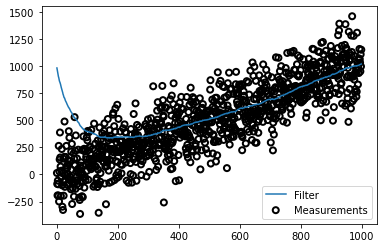

In [33]:
sensor_var = 30000.
process_var = 2.
pos = gaussian(1000., 500.)
process_model = gaussian(1., process_var)

N = 1000
ob = ObjectSimulation(0, 1, sensor_var, process_var)
zs = [ob.move_and_sense() for _ in range(N)]
ps = []

for z in zs:
    prior = predict(pos, process_model) 
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc=4);

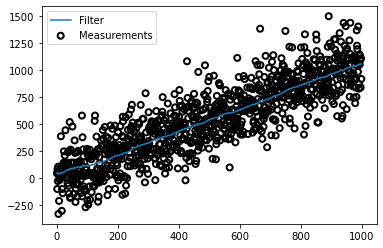

In [34]:
sensor_var = 30000.
process_var = 2.
process_model = gaussian(1., process_var)
N = 1000
ob = ObjectSimulation(0, 1, sensor_var, process_var)
zs = [ob.move_and_sense() for _ in range(N)]

pos = gaussian(zs[0], 500.)
ps = []
for z in zs:
    prior = predict(pos, process_model) 
    pos = update(prior, gaussian(z, sensor_var))
    ps.append(pos.mean)

book_plots.plot_measurements(zs, lw=1)
book_plots.plot_filter(ps)
plt.legend(loc='best');

## Нелинейные системы

$$\begin{aligned}
\mathcal{N}(\bar\mu,\, \bar\sigma^2) &= \mathcal{N}(\mu,\, \sigma^2) + \mathcal{N}(\mu_\mathtt{move},\, \sigma^2_\mathtt{move})\\
\mathcal{N}(\mu,\, \sigma^2) &= \mathcal{N}(\bar\mu,\, \bar\sigma^2)  \times \mathcal{N}(\mu_\mathtt{z},\, \sigma^2_\mathtt{z})
\end{aligned}$$



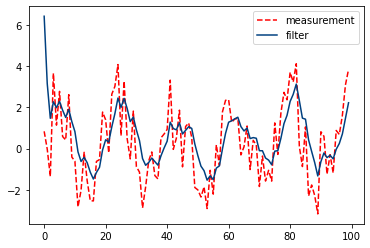

In [40]:
import math

sensor_var = 30.
process_var = 3.5
pos = gaussian(100., 500.)
process_model = gaussian(0.1, process_var)

zs, ps = [], []

for i in range(100):
    pos = predict(pos, process_model)

    z = math.sin(i/3.)*2 + randn()*1.2
    zs.append(z)
    
    pos = update(pos, gaussian(z, sensor_var))
    ps.append(pos.mean)

plt.plot(zs, c='r', linestyle='dashed', label='measurement')
plt.plot(ps, c='#004080', label='filter')
plt.legend(loc='best');

In [41]:
!java -version

"java" не является внутренней или внешней
командой, исполняемой программой или пакетным файлом.


## Итоги

Фильтр Калмана является особым, ограниченным случаем более общего фильтра, который мы изучим далее. Математика фильтра Калмана довольно сложна, и может быть трудно понять лежащую в основе простоту фильтра. Гауссовский фильтр является хорошим представлением унимодального представления о положении объекта, положении самолета в небе или температуре камеры химической реакции. Умножение гауссиан формирует новое представление из предыдущего состояния и нового измерения.
